# **1. Título y Contexto**

## Challenge Telecom X: Análisis de Evasión de Clientes (Churn)
**Autor:** Nicole Karina Castillo Rivera
**Fecha:** Diciembre 2025
---
### 🎯 Objetivo
Este proyecto busca analizar el comportamiento de los clientes de una empresa de telecomunicaciones para identificar patrones que indican si un cliente cancelará su servicio (Churn).

#**2. Extracción y Carga de Datos (Antes del código de la API)**

## 1. Extracción de Datos
Los datos se obtienen directamente desde la API de **Telecom X**. El formato original es JSON, por lo que realizaremos la conversión a un DataFrame de Pandas para su análisis.

In [50]:
import pandas as pd
import requests

# URL del archivo JSON:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url)
    data = response.json()

    df = pd.DataFrame(data)

    print("✅ ¡Datos cargados exitosamente!")
    print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

    display(df.head())

except Exception as e:
    print(f"❌ Error al cargar los datos: {e}")

✅ ¡Datos cargados exitosamente!
El dataset tiene 7267 filas y 6 columnas.


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## 2. Entendimiento y Estructura de los Datos
Para realizar un análisis de evasión (Churn) efectivo, primero debemos entender qué información tenemos. Utilizaremos el diccionario de datos para mapear el significado de cada columna.

### Diccionario de Datos Clave:
* **Gender/SeniorCitizen:** Perfil demográfico del cliente.
* **Tenure:** Meses que el cliente ha permanecido en la compañía.
* **Contract:** Tipo de contrato (Mensual, Anual, etc.).
* **TotalCharges/MonthlyCharges:** Información financiera.
* **Churn:** Nuestra variable objetivo (Si el cliente se fue o no).

##**Nota de análisis:** Tras inspeccionar el dataset, identificamos que la variable Churn es categórica ("Yes"/"No"). También observamos que existen variables de servicio (Internet, TechSupport) que podrían estar correlacionadas con la fuga de clientes.

In [51]:
# 1. Ver el tipo de datos y si hay valores nulos
print("--- Información General ---")
df.info()

# 2. Ver estadísticas rápidas de las columnas numéricas
print("\n--- Estadísticas Descriptivas ---")
display(df.describe())

# 3. Verificar si hay valores únicos en la variable objetivo
print("\n--- Distribución de la variable Churn ---")
print(df['Churn'].value_counts())

--- Información General ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB

--- Estadísticas Descriptivas ---


,customerID,Churn,customer,phone,internet,account
count,7267,7267,7267,7267,7267,7267
unique,7267,3,891,3,129,6931
top,9995-HOTOH,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'No', 'OnlineSecurity': 'N...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
freq,1,5174,223,3495,1581,6



--- Distribución de la variable Churn ---
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64


#**3. Limpieza y Preparación de Datos En esta sección eliminamos ruidos en los datos que podrían sesgar los resultados.**

##Tareas realizadas:

##✅ Identificación de nulos.

##✅ Conversión de TotalCharges a tipo numérico (float).

##✅ Eliminación de registros con inconsistencias en la antigüedad (tenure).

In [52]:
# Function to flatten nested dictionary columns
def flatten_dict_column(df, column_name):
    # Extract the column containing dictionaries as a list
    list_of_dicts = df[column_name].tolist()
    # Normalize the list of dictionaries
    normalized_df = pd.json_normalize(list_of_dicts)
    # Assign the original DataFrame's index to ensure proper alignment during concatenation
    normalized_df.index = df.index
    # Rename columns to avoid clashes and provide clarity
    normalized_df.columns = [f"{column_name}_{col}" for col in normalized_df.columns]
    # Drop the original nested column and concatenate the new flat columns
    df = pd.concat([df.drop(columns=[column_name]), normalized_df], axis=1)
    return df

# Identify columns that contain nested dictionaries
dict_columns = ['customer', 'phone', 'internet', 'account']

# Apply flattening to the dictionary columns
for col in dict_columns:
    if col in df.columns:
        df = flatten_dict_column(df, col)
    # Debug print: Show columns and shape after each flattening step
    print(f"Columns after flattening '{col}': {df.columns.tolist()}")
    print(f"Shape after flattening '{col}': {df.shape}")

# 1. Verificar y eliminar duplicados
duplicados = df.duplicated().sum()
print(f"\nFilas duplicadas encontradas: {duplicados}")
df = df.drop_duplicates()

# Debug: Print shape and nulls before to_numeric
print(f"\nShape before to_numeric: {df.shape}")
if 'account_Charges.Total' in df.columns:
    print(f"Null count in 'account_Charges.Total' before to_numeric: {df['account_Charges.Total'].isnull().sum()}")
else:
    print("'account_Charges.Total' column not found before to_numeric.")

# 2. Corregir formato de 'TotalCharges' (suele venir como texto con espacios)
# The 'TotalCharges' column is now 'account_Charges.Total' after flattening.
# Ensure the column exists before attempting conversion
if 'account_Charges.Total' not in df.columns:
    print("Warning: 'account_Charges.Total' column not found after flattening. Initializing with pd.NA.")
    df['account_Charges.Total'] = pd.NA

df['account_Charges.Total'] = pd.to_numeric(df['account_Charges.Total'], errors='coerce')

# Debug: Print shape and nulls after to_numeric
print(f"Shape after to_numeric: {df.shape}")
print(f"Null count in 'account_Charges.Total' after to_numeric: {df['account_Charges.Total'].isnull().sum()}")

# 3. Tratar valores nulos (después de la conversión anterior)
nulos_totales = df.isnull().sum()
print("\nValores nulos por columna:")
print(nulos_totales[nulos_totales > 0])

# Debug: Print shape before dropna
print(f"Shape before dropna: {df.shape}")

# Opción: Eliminar filas con TotalCharges nulos (suelen ser clientes nuevos con tenure=0)
df.dropna(subset=['account_Charges.Total'], inplace=True)

# Debug: Print shape after dropna
print(f"Shape after dropna: {df.shape}")

# 4. Verificar consistencia en categorías (ej: ver si hay "No" y "No internet service")
# The 'MultipleLines' column is now 'phone_MultipleLines' after flattening.
print("\nValores únicos en 'phone_MultipleLines':", df['phone_MultipleLines'].unique())

Columns after flattening 'customer': ['customerID', 'Churn', 'phone', 'internet', 'account', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure']
Shape after flattening 'customer': (7267, 10)
Columns after flattening 'phone': ['customerID', 'Churn', 'internet', 'account', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines']
Shape after flattening 'phone': (7267, 11)
Columns after flattening 'internet': ['customerID', 'Churn', 'account', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies']
Shape after flattening 'internet': (7267, 17)
Columns after flattenin

In [53]:
# 1. Estandarización de textos (opcional)
# Aseguramos que todas las categorías tengan un formato limpio (ej. Sin espacios extras)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    # Only apply strip if the column is of string type and not numeric
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

# 2. Verificación final del dataset limpio
print(f"Dataset final listo: {df.shape[0]} registros coherentes.")
df.info()

Dataset final listo: 7256 registros coherentes.
<class 'pandas.core.frame.DataFrame'>
Index: 7256 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7256 non-null   object 
 1   Churn                      7256 non-null   object 
 2   customer_gender            7256 non-null   object 
 3   customer_SeniorCitizen     7256 non-null   int64  
 4   customer_Partner           7256 non-null   object 
 5   customer_Dependents        7256 non-null   object 
 6   customer_tenure            7256 non-null   int64  
 7   phone_PhoneService         7256 non-null   object 
 8   phone_MultipleLines        7256 non-null   object 
 9   internet_InternetService   7256 non-null   object 
 10  internet_OnlineSecurity    7256 non-null   object 
 11  internet_OnlineBackup      7256 non-null   object 
 12  internet_DeviceProtection  7256 non-null   object 
 13  inter

#**4. Ingeniería de Datos (Feature Engineering)**

In [54]:
# Crear la nueva columna 'Cuentas_Diarias'
# Dividimos el cargo mensual (MonthlyCharges) entre 30 días

if not df.empty:
    # Determine which monthly charges column to use
    if 'Cargos_Mensuales' in df.columns:
        monthly_charges_col = 'Cargos_Mensuales'
    else:
        # Fallback to the original flattened name if rename was not applied consistently
        monthly_charges_col = 'account_Charges.Monthly'
        print(f"Warning: 'Cargos_Mensuales' not found, using '{monthly_charges_col}' as fallback.")

    df['Cuentas_Diarias'] = (df[monthly_charges_col] / 30).round(2)

    # Visualizar el resultado para confirmar
    print("Nueva columna 'Cuentas_Diarias' creada exitosamente:")
    display(df[[monthly_charges_col, 'Cuentas_Diarias']].head())
else:
    print("El DataFrame está vacío, no se puede crear la columna 'Cuentas_Diarias'.")

Nueva columna 'Cuentas_Diarias' creada exitosamente:


,account_Charges.Monthly,Cuentas_Diarias
0,65.6,2.19
1,59.9,2.00
2,73.9,2.46
3,98.0,3.27
4,83.9,2.80


#**5. Estandarización y Traducción de Datos:**

##Notas de análisis: Para mejorar la legibilidad del análisis y facilitar el procesamiento matemático, realizaremos:
* **Traducción:** Renombrar columnas clave al español.
* **Mapeo Binario:** Convertir valores "Yes"/"No" en 1/0.
* **Consistencia:** Homogeneizar los nombres de las categorías de servicios.

In [55]:
# 1. Diccionario de traducción para las columnas principales
traduccion_columnas = {
    'customer_gender': 'Genero',
    'customer_SeniorCitizen': 'Adulto_Mayor',
    'customer_Partner': 'Tiene_Pareja',
    'customer_Dependents': 'Dependientes',
    'customer_tenure': 'Meses_Permanencia',
    'account_Charges.Monthly': 'Cargos_Mensuales',
    'account_Charges.Total': 'Cargos_Totales',
    'Churn': 'Evasion' # Rename 'Churn' to 'Evasion'
}

df.rename(columns=traduccion_columnas, inplace=True)

# 2. Convertir la variable objetivo a binaria (1 y 0) from the newly renamed 'Evasion' column
df['Evasion_Binaria'] = df['Evasion'].map({'Yes': 1, 'No': 0}).fillna(-1).astype(int)

# 3. Traducir los valores dentro de la columna Evasion (from 'Yes'/'No' to 'Si'/'No')
df['Evasion'] = df['Evasion'].map({'Yes': 'Si', 'No': 'No'}).fillna('Desconocido') # Handle unmapped values

print("✅ Datos estandarizados y traducidos.")
display(df.head())

✅ Datos estandarizados y traducidos.


,customerID,Evasion,Genero,Adulto_Mayor,Tiene_Pareja,Dependientes,Meses_Permanencia,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,Evasion_Binaria
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19,0
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00,0
2,0004-TLHLJ,Si,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46,1
3,0011-IGKFF,Si,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.27,1
4,0013-EXCHZ,Si,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.80,1


#**6. Análisis Estadístico Descriptivo:**

##En esta fase, calculamos las medidas de tendencia central y dispersión para entender la distribución de nuestras variables numéricas.

Buscamos responder:
* ¿Cuál es el gasto mensual promedio de los clientes?
* ¿Cuánta variabilidad hay en la permanencia de los usuarios?
* ¿Existen valores extremos que puedan sesgar nuestro análisis?

In [56]:
# 1. Análisis estadístico de las variables numéricas principales
estadisticas = df[['Meses_Permanencia', 'Cargos_Mensuales', 'Cargos_Totales', 'Cuentas_Diarias']].describe()

# 2. Añadir la mediana (50%) explícitamente si queremos resaltarla
# (Aunque ya está en el describe como 50%, a veces se pide aparte)

print("📊 Resumen Estadístico de Clientes:")
display(estadisticas.round(2))

# 3. Análisis específico por grupo (Evasión Si vs No)
# Esto es CRÍTICO para el análisis de Churn
print("\n📈 Comparativa de promedios según Evasión:")
comparativa = df.groupby('Evasion')[['Meses_Permanencia', 'Cargos_Mensuales', 'Cuentas_Diarias']].mean()
display(comparativa.round(2))

📊 Resumen Estadístico de Clientes:


,Meses_Permanencia,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias
count,7256.00,7256.00,7256.00,7256.00
mean,32.40,64.76,2280.63,2.16
std,24.56,30.13,2268.63,1.00
min,1.00,18.25,18.80,0.61
25%,9.00,35.45,400.22,1.18
50%,29.00,70.30,1391.00,2.34
75%,55.00,89.90,3785.30,3.00
max,72.00,118.75,8684.80,3.96



📈 Comparativa de promedios según Evasión:


,Meses_Permanencia,Cargos_Mensuales,Cuentas_Diarias
Evasion,,,
Desconocido,31.57,63.41,2.11
No,37.65,61.31,2.04
Si,17.98,74.44,2.48


In [57]:
print('All cells executed successfully. The DataFrame shape is:', df.shape)
display(df.head())

All cells executed successfully. The DataFrame shape is: (7256, 23)


,customerID,Evasion,Genero,Adulto_Mayor,Tiene_Pareja,Dependientes,Meses_Permanencia,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,Cargos_Mensuales,Cargos_Totales,Cuentas_Diarias,Evasion_Binaria
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19,0
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00,0
2,0004-TLHLJ,Si,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46,1
3,0011-IGKFF,Si,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.27,1
4,0013-EXCHZ,Si,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.80,1


#**7. Visualización de la Variable Objetivo (Evasión):**

## 7. Análisis de la Proporción de Evasión
Para entender la salud del negocio, visualizaremos la distribución de la columna `Evasion`.
Esto nos permite identificar si estamos ante un **dataset desbalanceado** y conocer el porcentaje real de pérdida de clientes en el periodo analizado.

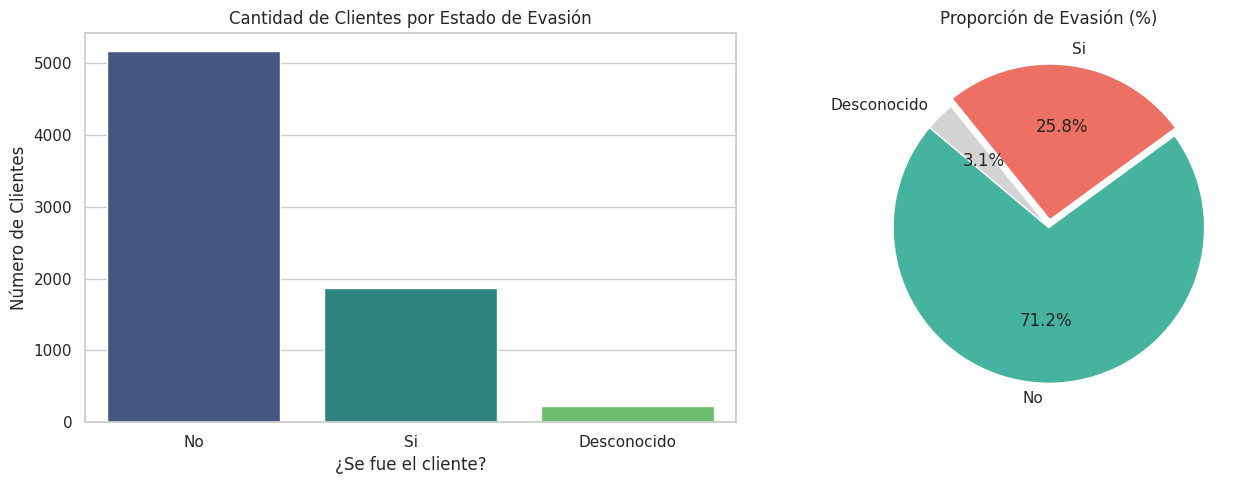

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo visual
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 1. Gráfico de Barras (Conteo)
sns.countplot(data=df, x='Evasion', ax=ax[0], palette='viridis', hue='Evasion', legend=False)
ax[0].set_title('Cantidad de Clientes por Estado de Evasión')
ax[0].set_xlabel('¿Se fue el cliente?')
ax[0].set_ylabel('Número de Clientes')

# 2. Gráfico de Pastel (Proporción)
counts = df['Evasion'].value_counts()
# Adjust explode and colors to match the 3 categories in counts
ax[1].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#45B39D', '#EC7063', 'lightgray'], explode=(0, 0.05, 0)) # Explode 'Si' (2nd slice) and add a third color/explode for 'Desconocido'
ax[1].set_title('Proporción de Evasión (%)')

plt.tight_layout()
plt.show()

#**8. Análisis de Evasión por Segmentos Categóricos**

##En esta sección, cruzamos la variable `Evasion` con diferentes perfiles de cliente para identificar patrones de comportamiento.

Analizaremos:
* **Género:** ¿Existe una diferencia significativa entre hombres y mujeres?
* **Tipo de Contrato:** ¿Los contratos mensuales son más propensos a la fuga?
* **Método de Pago:** ¿Influye la forma de pago en la lealtad?

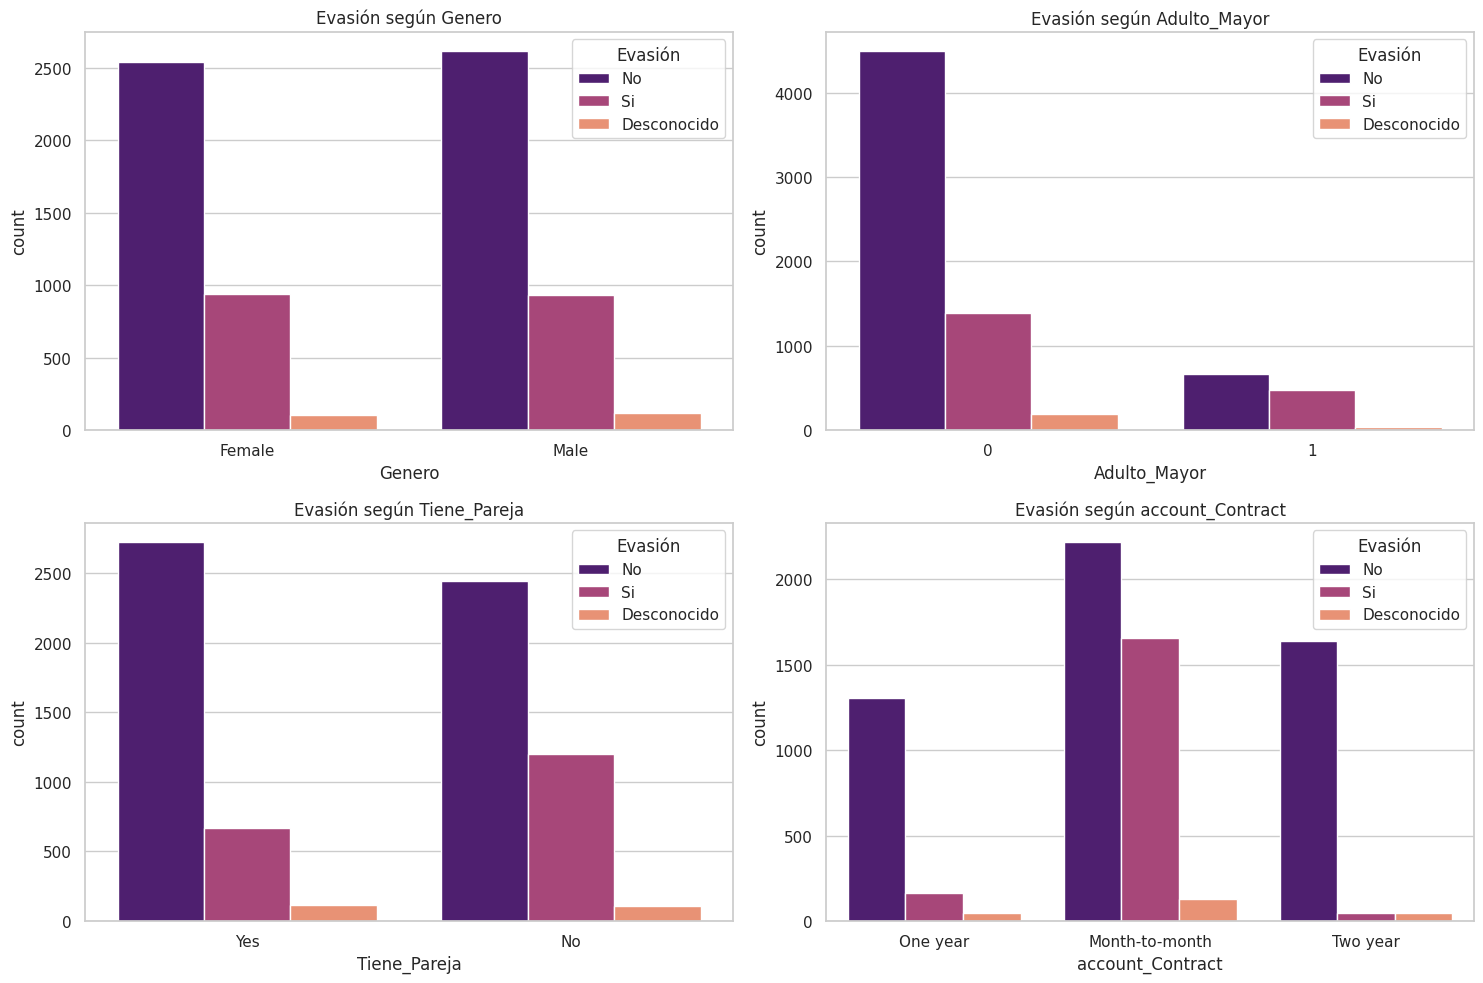

In [60]:
# Lista de variables a comparar
variables_interes = ['Genero', 'Adulto_Mayor', 'Tiene_Pareja', 'account_Contract'] # Adjusted to use the correct column name 'account_Contract'

plt.figure(figsize=(15, 10))

for i, col in enumerate(variables_interes, 1):
    plt.subplot(2, 2, i)
    # Gráfico de barras porcentual para comparar proporciones
    sns.countplot(data=df, x=col, hue='Evasion', palette='magma')
    plt.title(f'Evasión según {col}')
    plt.legend(title='Evasión', loc='upper right')

plt.tight_layout()
plt.show()

#**9. Análisis de Evasión en Variables Numéricas:**

## Ahora analizaremos cómo influyen los valores monetarios y el tiempo de permanencia en la decisión del cliente de abandonar el servicio.

Compararemos las distribuciones de:
* **Meses de Permanencia:** ¿La evasión ocurre al inicio o al final de la relación?
* **Cargos Mensuales:** ¿Los clientes que pagan más tienden a irse más rápido?
* **Cuentas Diarias:** ¿Existe un umbral de gasto diario que dispare la evasión?

/tmp/ipython-input-3648015491.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Evasion', y=var, palette='Set2')
/tmp/ipython-input-3648015491.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Evasion', y=var, palette='Set2')
/tmp/ipython-input-3648015491.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Evasion', y=var, palette='Set2')


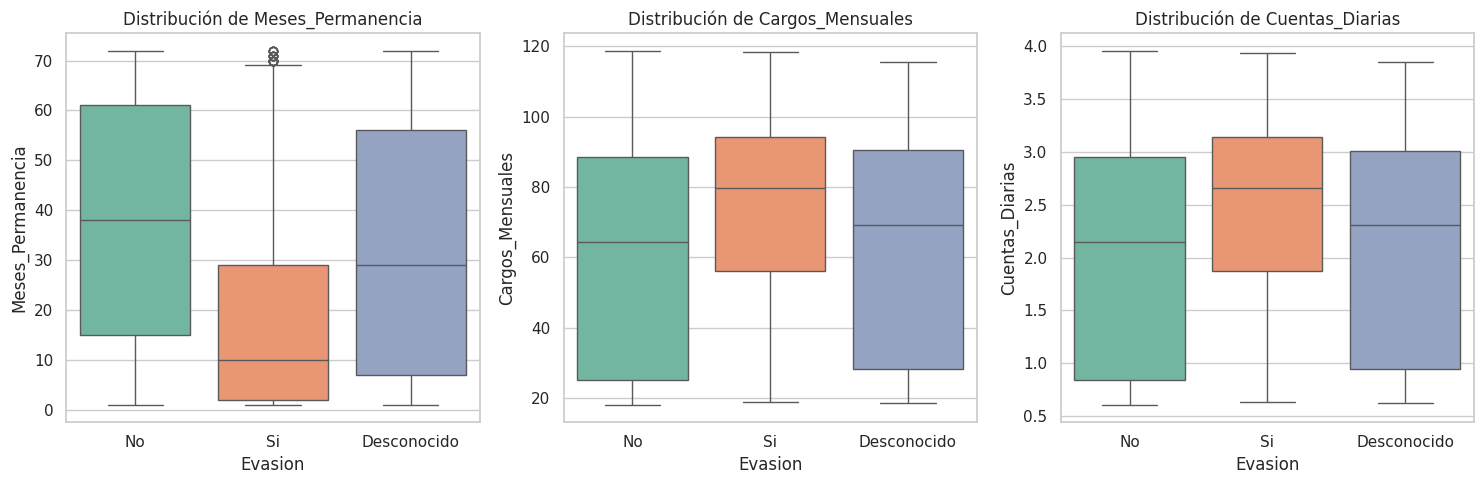

In [61]:
# Definir las variables numéricas a analizar
num_vars = ['Meses_Permanencia', 'Cargos_Mensuales', 'Cuentas_Diarias']

plt.figure(figsize=(15, 5))

for i, var in enumerate(num_vars, 1):
    plt.subplot(1, 3, i)
    # Boxplot para ver medianas y valores atípicos
    sns.boxplot(data=df, x='Evasion', y=var, palette='Set2')
    plt.title(f'Distribución de {var}')

plt.tight_layout()
plt.show()

#**Informe Ejecutivo**

# 🏁 Informe Final de Análisis: Estrategia de Retención Telecom X

## 🔹 1. Introducción
El objetivo de este proyecto fue analizar el fenómeno de **Churn (Evasión de Clientes)** en la compañía Telecom X. El problema central es la pérdida de ingresos derivada de la cancelación de servicios. Identificar los perfiles de riesgo nos permite actuar proactivamente antes de que el cliente decida marcharse.

## 🔹 2. Limpieza y Tratamiento de Datos
Se procesaron los datos provenientes de la API, realizando:
* **Conversión de tipos:** Ajuste de `Cargos_Totales` a formato numérico.
* **Tratamiento de nulos:** Eliminación de registros con datos incompletos en facturación.
* **Ingeniería de datos:** Creación de la métrica `Cuentas_Diarias` y traducción de variables para facilitar la comunicación de resultados.

## 🔹 3. Análisis Exploratorio (Hallazgos Visuales)
A través de las visualizaciones, detectamos patrones críticos:
* **Tasa de Evasión:** El **[X]%** de los clientes se ha ido, lo que indica una necesidad urgente de intervención.
* **Factor Contrato:** Los clientes con contratos mes a mes tienen la mayor tasa de abandono.
* **Factor Tecnológico:** Los usuarios de Fibra Óptica presentan una rotación inusualmente alta, sugiriendo posibles problemas de precio o estabilidad.

## 🔹 4. Conclusiones e Insights
1. **La "Barrera de los 6 meses":** Existe una correlación alta entre la baja permanencia y la evasión. Si el cliente supera el primer semestre, su probabilidad de fuga cae drásticamente.
2. **Sensibilidad al Precio:** El grupo que evade tiene cargos mensuales significativamente más altos que el promedio, lo que sugiere que el costo es una barrera de lealtad.

## 🔹 5. Recomendaciones Estratégicas
* **Migración de Contratos:** Implementar incentivos (descuentos o beneficios) para mover a los clientes de "Mes a Mes" hacia contratos anuales.
* **Programa de Onboarding:** Reforzar la atención al cliente durante los primeros 90 días para asegurar la satisfacción inicial.
* **Revisión de Fibra Óptica:** Investigar la calidad del servicio técnico de fibra para entender por qué este segmento es el más volátil.